## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Data Preparation

In [2]:
# Define dataset directories
train_dir = "../Dataset for CA1 part A - AY2526S1/train"
val_dir = "../Dataset for CA1 part A - AY2526S1/validation"
test_dir = "../Dataset for CA1 part A - AY2526S1/test"

In [3]:
# Create a function to load the dataset, convert it to grayscale and resize it to the target size
def load_dataset(data_dir, target_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(224, 224),  # Load original size first
        batch_size=32,
        label_mode="int",  # or 'categorical' if needed
        shuffle=True,
    )

    # Convert RGB to grayscale and resize to target size
    def preprocess(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, target_size)
        return image, label

    dataset = dataset.map(preprocess)
    return dataset

In [4]:
# Create datasets for both sizes
train_23 = load_dataset(train_dir, (23,23))
val_23 = load_dataset(val_dir, (23,23))
test_23 = load_dataset(test_dir, (23,23))

train_101 = load_dataset(train_dir, (101,101))
val_101 = load_dataset(val_dir, (101,101))
test_101 = load_dataset(test_dir, (101,101))

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [5]:
# Verify one sample from each
def inspect_dataset(dataset, name):
    for images, labels in dataset.take(1):
        print(f"\n{name} - Batch info:")
        print("Image shape:", images.shape)
        print("Label shape:", labels.shape)
        print("Pixel range:", (images.numpy().min(), images.numpy().max()))
        if hasattr(dataset, 'class_names'):
            print("Classes:", dataset.class_names)
        else:
            print("Class names not available in dataset object")

inspect_dataset(train_23, "Train 23x23")
inspect_dataset(val_101, "Validation 101x101")


Train 23x23 - Batch info:
Image shape: (32, 23, 23, 1)
Label shape: (32,)
Pixel range: (0.0, 254.97452)
Class names not available in dataset object

Validation 101x101 - Batch info:
Image shape: (32, 101, 101, 1)
Label shape: (32,)
Pixel range: (0.0, 254.97452)
Class names not available in dataset object


23x23 Samples:


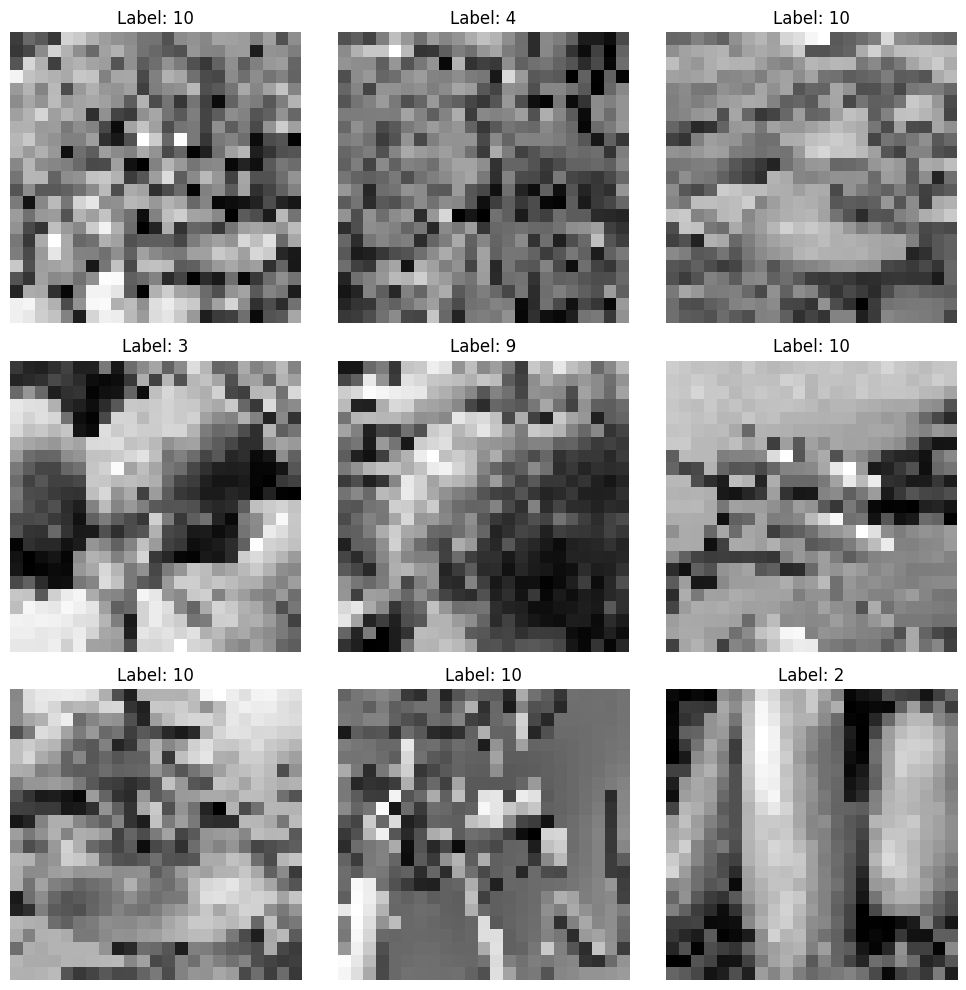


101x101 Samples:


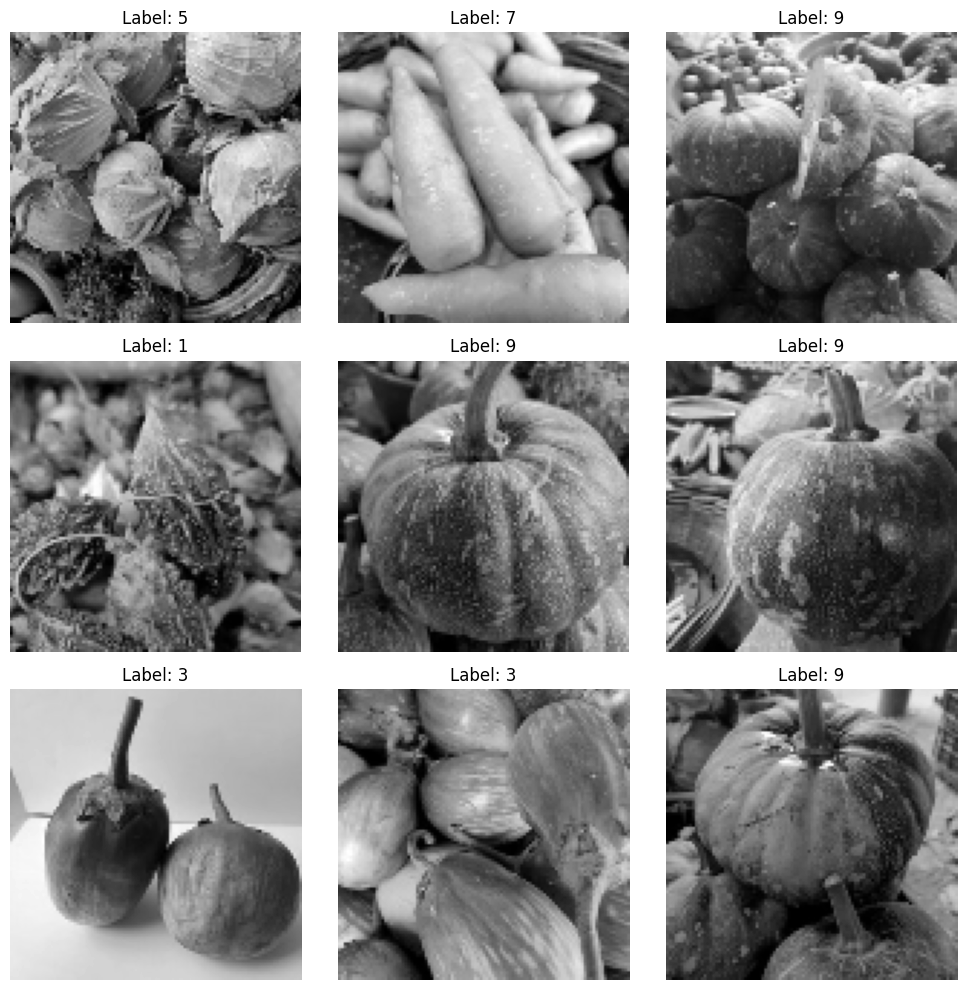

In [6]:
# View the first 9 samples of the training set
def show_samples(dataset, n=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(min(n, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()


print("23x23 Samples:")
show_samples(train_23)

print("\n101x101 Samples:")
show_samples(train_101)

In [7]:
# Load just the class names without processing images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

print("\nClasses detected by TensorFlow:")
print(train_ds.class_names)

Found 7699 files belonging to 11 classes.

Classes detected by TensorFlow:
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']


In [8]:
# Ensure preprocessing of the dataset was done correctly
def verify_preprocessing(dataset, expected_size):
    batch = next(iter(dataset.take(1)))
    images, _ = batch

    print("\nPreprocessing Verification:")
    print(f"Expected size: {expected_size}")
    print(f"Actual size: {images.shape[1:3]}")
    print(f"Channels: {images.shape[-1]} (1=grayscale)")
    print(f"Normalization check:")
    print(f"Min: {tf.reduce_min(images):.4f}, Max: {tf.reduce_max(images):.4f}")


verify_preprocessing(train_23, (23, 23))
verify_preprocessing(train_101, (101, 101))


Preprocessing Verification:
Expected size: (23, 23)
Actual size: (23, 23)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 253.0019

Preprocessing Verification:
Expected size: (101, 101)
Actual size: (101, 101)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 254.9745


## Fully Connected Model (Baseline)


Training 23x23 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 7s 15ms/step - loss: 14.7365 - accuracy: 0.1137 - val_loss: 2.4077 - val_accuracy: 0.0918
Epoch 2/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3822 - accuracy: 0.1220 - val_loss: 2.4162 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3578 - accuracy: 0.1235 - val_loss: 2.4272 - val_accuracy: 0.0905
Epoch 4/50
241/241 [==============================] - 2s 9ms/step - loss: 2.3554 - accuracy: 0.1129 - val_loss: 2.4349 - val_accuracy: 0.0909
Epoch 5/50
241/241 [==============================] - 2s 9ms/step - loss: 2.3511 - accuracy: 0.1159 - val_loss: 2.4410 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 2s 9ms/step - loss: 2.3489 - accuracy: 0.1212 - val_loss: 2.4458 - val_accuracy: 0.0909


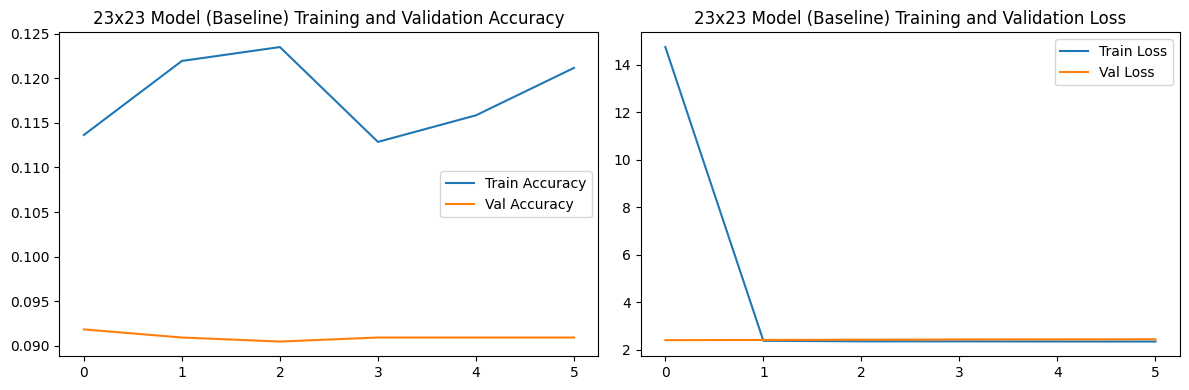

69/69 [==============================] - 1s 7ms/step - loss: 2.4463 - accuracy: 0.0909
23x23 Model (Baseline) - Test Accuracy: 0.0909
23x23 Model (Baseline) - Test Loss: 2.4463

Training 101x101 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 3s 9ms/step - loss: 45.1048 - accuracy: 0.1152 - val_loss: 2.4059 - val_accuracy: 0.0914
Epoch 2/50
241/241 [==============================] - 2s 9ms/step - loss: 2.3745 - accuracy: 0.1235 - val_loss: 2.4130 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 2s 8ms/step - loss: 2.3562 - accuracy: 0.1251 - val_loss: 2.4235 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 2s 8ms/step - loss: 2.3528 - accuracy: 0.1248 - val_loss: 2.4313 - val_accuracy: 0.0909
Epoch 5/50
241/241 [==============================] - 2s 8ms/step - loss: 2.3506 - accuracy: 0.1237 - val_loss: 2.4371 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 2s 8ms/step - loss: 

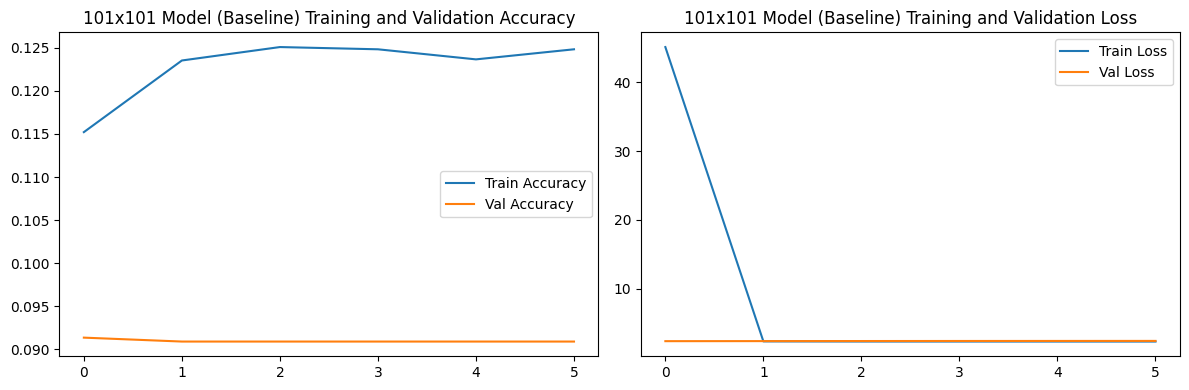

69/69 [==============================] - 0s 6ms/step - loss: 2.4415 - accuracy: 0.0909
101x101 Model (Baseline) - Test Accuracy: 0.0909
101x101 Model (Baseline) - Test Loss: 2.4415


In [9]:
# Function to create a simple fully connected model (baseline)
def create_fc_baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),  # Flatten input to 1D
        layers.Dense(128, activation='relu'),     # Hidden layer with 128 neurons
        layers.Dropout(0.5),                      # Dropout layer to prevent overfitting
        layers.Dense(64, activation='relu'),      # Another hidden layer with 64 neurons
        layers.Dropout(0.5),                      # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer with 'softmax' activation
    ])
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Function to train the FC model and plot the training history
def train_fc_baseline_model(input_shape, num_classes, train_ds, val_ds, test_ds, model_name, epochs=50):
    # Create the model
    model = create_fc_baseline_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_ds,  # Training dataset
        validation_data=val_ds,  # Validation dataset
        epochs=epochs,  # Number of epochs
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],  # Early stopping to prevent overfitting
        verbose=1
    )
    
    # Plotting Training History
    plt.figure(figsize=(12, 4))
    
    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()
    
    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Evaluate on the test dataset
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} - Test Loss: {test_loss:.4f}")

    return model


# Example usage:

# 23x23 Model (Baseline)
print("\nTraining 23x23 Model (Baseline)...")
input_shape_23 = (23, 23, 1)  # For grayscale images of size 23x23 pixels
num_classes = 11  # 11 classes for classification (vegetables)
fc_baseline_model_23 = train_fc_baseline_model(input_shape_23, num_classes, train_23, val_23, test_23, "23x23 Model (Baseline)")

# 101x101 Model (Baseline)
print("\nTraining 101x101 Model (Baseline)...")
input_shape_101 = (101, 101, 1)  # For grayscale images of size 101x101 pixels
fc_baseline_model_101 = train_fc_baseline_model(input_shape_101, num_classes, train_101, val_101, test_101, "101x101 Model (Baseline)")


## Training CNN Models

In [10]:
# Create Function to Create the Model with the Following Layers by Passing in the Input Shape
def create_model(input_shape):
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(11, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
# Define Function to train the CNN Model
def train_model(model, train_ds, val_ds, model_name):
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5)
    checkpoint = callbacks.ModelCheckpoint(
        f"best_{model_name}.h5", save_best_only=True, monitor="val_accuracy"
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping, checkpoint],
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training.png")
    plt.show()

    return model

Training 23x23 model...
Epoch 1/50
241/241 [==============================] - 8s 9ms/step - loss: 2.4909 - accuracy: 0.1773 - val_loss: 2.1364 - val_accuracy: 0.2618
Epoch 2/50
241/241 [==============================] - 2s 8ms/step - loss: 2.0314 - accuracy: 0.2945 - val_loss: 1.9446 - val_accuracy: 0.3495
Epoch 3/50
241/241 [==============================] - 2s 8ms/step - loss: 1.8052 - accuracy: 0.3819 - val_loss: 1.7785 - val_accuracy: 0.3859
Epoch 4/50
241/241 [==============================] - 2s 8ms/step - loss: 1.5744 - accuracy: 0.4742 - val_loss: 1.5804 - val_accuracy: 0.4609
Epoch 5/50
241/241 [==============================] - 2s 8ms/step - loss: 1.3741 - accuracy: 0.5286 - val_loss: 1.4065 - val_accuracy: 0.5214
Epoch 6/50
241/241 [==============================] - 2s 8ms/step - loss: 1.1902 - accuracy: 0.5923 - val_loss: 1.1921 - val_accuracy: 0.5959
Epoch 7/50
241/241 [==============================] - 2s 8ms/step - loss: 1.0335 - accuracy: 0.6529 - val_loss: 1.3291 - val

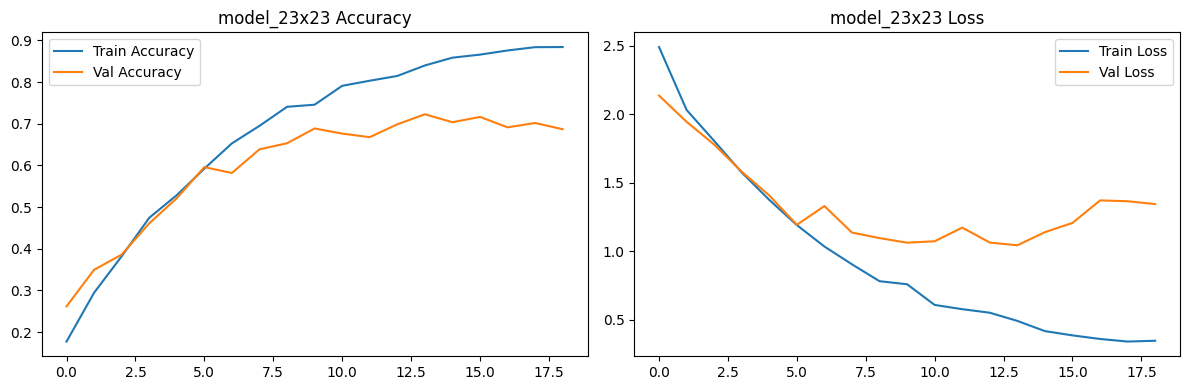

In [12]:
# Train the Models for the 2 different Input Sizes
print("Training 23x23 model...")
model_23 = create_model((23, 23, 1))
train_model(model_23, train_23, val_23, "model_23x23")


Training 101x101 model...
Epoch 1/50
241/241 [==============================] - 5s 18ms/step - loss: 4.5638 - accuracy: 0.1192 - val_loss: 2.4012 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3687 - accuracy: 0.1213 - val_loss: 2.4096 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 5s 21ms/step - loss: 2.3582 - accuracy: 0.1233 - val_loss: 2.4191 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 5s 21ms/step - loss: 2.3528 - accuracy: 0.1222 - val_loss: 2.4274 - val_accuracy: 0.0909
Epoch 5/50
241/241 [==============================] - 5s 21ms/step - loss: 2.3501 - accuracy: 0.1203 - val_loss: 2.4345 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 5s 20ms/step - loss: 2.3487 - accuracy: 0.1216 - val_loss: 2.4398 - val_accuracy: 0.0909


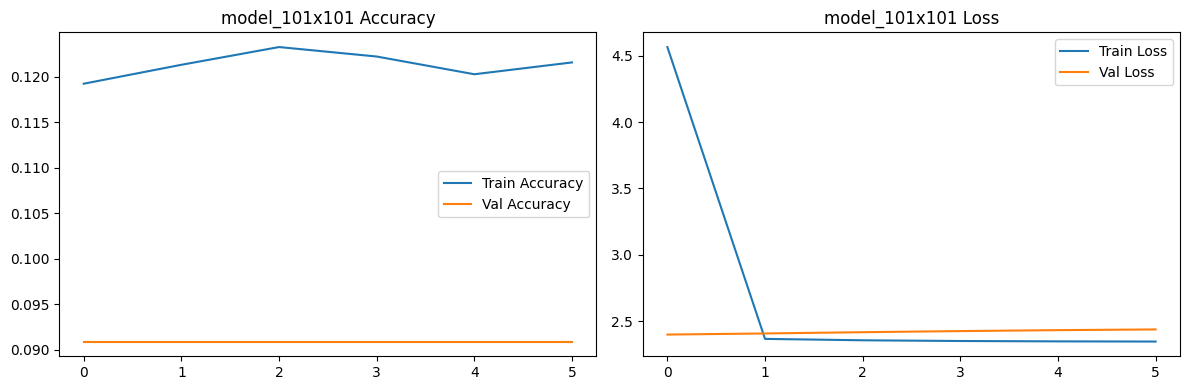

In [13]:
print("\nTraining 101x101 model...")
model_101 = create_model((101, 101, 1))
train_model(model_101, train_101, val_101, "model_101x101")

In [14]:
# Evaluate the model's Performance using the Test Dataset
# Evaluation with basic metrics
def evaluate_model_basic(model, test_ds, model_name):
    print(f"\nEvaluating {model_name}:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    return loss, accuracy


# Get metrics for comparison
loss_23, acc_23 = evaluate_model_basic(model_23, test_23, "23x23 Model")
loss_101, acc_101 = evaluate_model_basic(model_101, test_101, "101x101 Model")

print(f"\nAccuracy Improvement: {(acc_101-acc_23):.4f}")
print(f"Loss Reduction: {(loss_23-loss_101):.4f}")


Evaluating 23x23 Model:
Test Loss: 1.3728
Test Accuracy: 0.6882
Error Rate: 0.3118

Evaluating 101x101 Model:
Test Loss: 2.4398
Test Accuracy: 0.0909
Error Rate: 0.9091

Accuracy Improvement: -0.5973
Loss Reduction: -1.0670


## Improving the CNN Models

In [15]:
def create_improved_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax'),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def train_improved_model(model, train_ds, val_ds, model_name, epochs=50):
    print(f"\nTraining {model_name} (Improved) model...")

    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    checkpoint = callbacks.ModelCheckpoint(
        f"best_{model_name}_improved.h5", save_best_only=True, monitor="val_accuracy"
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy (Improved)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss (Improved)")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_improved.png")
    plt.show()

    return model



Training model_23x23 (Improved) model...
Epoch 1/50
241/241 [==============================] - 3s 10ms/step - loss: 1.8740 - accuracy: 0.3767 - val_loss: 1.7823 - val_accuracy: 0.3845
Epoch 2/50
241/241 [==============================] - 2s 9ms/step - loss: 1.2902 - accuracy: 0.5749 - val_loss: 1.5104 - val_accuracy: 0.5082
Epoch 3/50
241/241 [==============================] - 2s 9ms/step - loss: 0.9943 - accuracy: 0.6762 - val_loss: 1.1773 - val_accuracy: 0.6095
Epoch 4/50
241/241 [==============================] - 2s 9ms/step - loss: 0.8110 - accuracy: 0.7371 - val_loss: 1.1083 - val_accuracy: 0.6327
Epoch 5/50
241/241 [==============================] - 2s 10ms/step - loss: 0.6425 - accuracy: 0.7897 - val_loss: 1.8846 - val_accuracy: 0.5041
Epoch 6/50
241/241 [==============================] - 2s 9ms/step - loss: 0.5500 - accuracy: 0.8188 - val_loss: 1.0769 - val_accuracy: 0.6809
Epoch 7/50
241/241 [==============================] - 2s 9ms/step - loss: 0.4282 - accuracy: 0.8609 - va

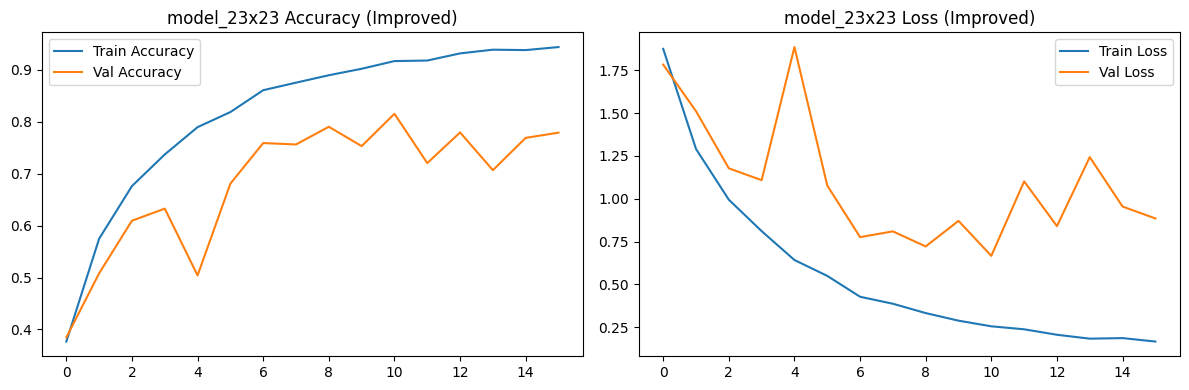


Training model_101x101 (Improved) model...
Epoch 1/50
241/241 [==============================] - 5s 18ms/step - loss: 1.5836 - accuracy: 0.4717 - val_loss: 2.5658 - val_accuracy: 0.3127
Epoch 2/50
241/241 [==============================] - 4s 18ms/step - loss: 0.9878 - accuracy: 0.6836 - val_loss: 1.9705 - val_accuracy: 0.4309
Epoch 3/50
241/241 [==============================] - 4s 18ms/step - loss: 0.7324 - accuracy: 0.7680 - val_loss: 3.4464 - val_accuracy: 0.3377
Epoch 4/50
241/241 [==============================] - 4s 17ms/step - loss: 0.5486 - accuracy: 0.8263 - val_loss: 0.9174 - val_accuracy: 0.6623
Epoch 5/50
241/241 [==============================] - 4s 18ms/step - loss: 0.4274 - accuracy: 0.8692 - val_loss: 3.6476 - val_accuracy: 0.3991
Epoch 6/50
241/241 [==============================] - 5s 20ms/step - loss: 0.3489 - accuracy: 0.8931 - val_loss: 6.0207 - val_accuracy: 0.3914
Epoch 7/50
241/241 [==============================] - 5s 21ms/step - loss: 0.2992 - accuracy: 0.90

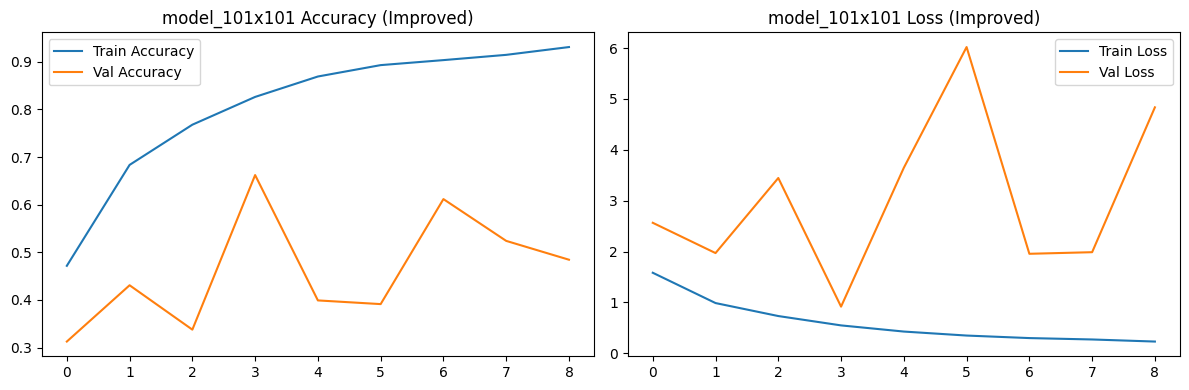

In [17]:
# Create improved models
improved_model_23 = create_improved_model((23, 23, 1))
improved_model_101 = create_improved_model((101, 101, 1))

# Train improved models
improved_model_23 = train_improved_model(improved_model_23, train_23, val_23, "model_23x23")
improved_model_101 = train_improved_model(improved_model_101, train_101, val_101, "model_101x101")

In [18]:
# Evaluate the improved model's performance using the test dataset
def evaluate_model_basic_improved(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Improved):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy


# Evaluate improved models
loss_23_improved, acc_23_improved = evaluate_model_basic_improved(improved_model_23, test_23, "23x23 Model")
loss_101_improved, acc_101_improved = evaluate_model_basic_improved(improved_model_101, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")



Evaluating 23x23 Model (Improved):
Test Loss: 0.6765
Test Accuracy: 0.7986
Error Rate: 0.2014

Evaluating 101x101 Model (Improved):
Test Loss: 0.8774
Test Accuracy: 0.6795
Error Rate: 0.3205

Accuracy Improvement (101x101 - 23x23): -0.1191
Loss Reduction (23x23 - 101x101): -0.2009


## Implement Hyperparameter Tuning for the 23x23 Model

In [23]:
import keras_tuner as kt

# Define the model-building function for Keras Tuner
def build_23_model_with_hyperparameters(hp):
    tuned_23_model = models.Sequential()
    
    # Conv Layer 1
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(23, 23, 1)
    ))
    tuned_23_model.add(layers.BatchNormalization())
    tuned_23_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    tuned_23_model.add(layers.BatchNormalization())
    tuned_23_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    tuned_23_model.add(layers.BatchNormalization())
    
    tuned_23_model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    tuned_23_model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    tuned_23_model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    tuned_23_model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    tuned_23_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return tuned_23_model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_23_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=50,
    directory='kt_dir',
    project_name='improved_23_model_tuning'
)

Reloading Tuner from kt_dir\improved_23_model_tuning\tuner0.json


In [24]:
# Run hyperparameter tuning
tuner.search(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")


Best Hyperparameters: {'conv_1_filters': 64, 'conv_2_filters': 192, 'conv_3_filters': 384, 'dense_units': 384, 'dropout_rate': 0.5, 'learning_rate': 0.00028745791047186465}


In [25]:
# Build and train the model with the best hyperparameters
tuned_23_model = tuner.hypermodel.build(best_hps)
history = tuned_23_model.fit(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)


Epoch 1/50
241/241 [==============================] - 3s 11ms/step - loss: 1.6994 - accuracy: 0.4360 - val_loss: 1.4763 - val_accuracy: 0.5032
Epoch 2/50
241/241 [==============================] - 3s 10ms/step - loss: 1.0652 - accuracy: 0.6485 - val_loss: 1.0936 - val_accuracy: 0.6314
Epoch 3/50
241/241 [==============================] - 3s 10ms/step - loss: 0.7338 - accuracy: 0.7656 - val_loss: 0.8260 - val_accuracy: 0.7305
Epoch 4/50
241/241 [==============================] - 3s 10ms/step - loss: 0.5042 - accuracy: 0.8456 - val_loss: 0.8733 - val_accuracy: 0.7095
Epoch 5/50
241/241 [==============================] - 3s 11ms/step - loss: 0.3649 - accuracy: 0.8913 - val_loss: 0.6754 - val_accuracy: 0.7755
Epoch 6/50
241/241 [==============================] - 3s 11ms/step - loss: 0.2498 - accuracy: 0.9262 - val_loss: 0.6960 - val_accuracy: 0.7927
Epoch 7/50
241/241 [==============================] - 3s 11ms/step - loss: 0.1715 - accuracy: 0.9525 - val_loss: 0.5779 - val_accuracy: 0.8195

In [26]:
# Evaluate the best model
test_loss, test_acc = tuned_23_model.evaluate(test_23)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


69/69 [==============================] - 1s 6ms/step - loss: 0.6545 - accuracy: 0.8114
Test Accuracy: 0.8114
Test Loss: 0.6545


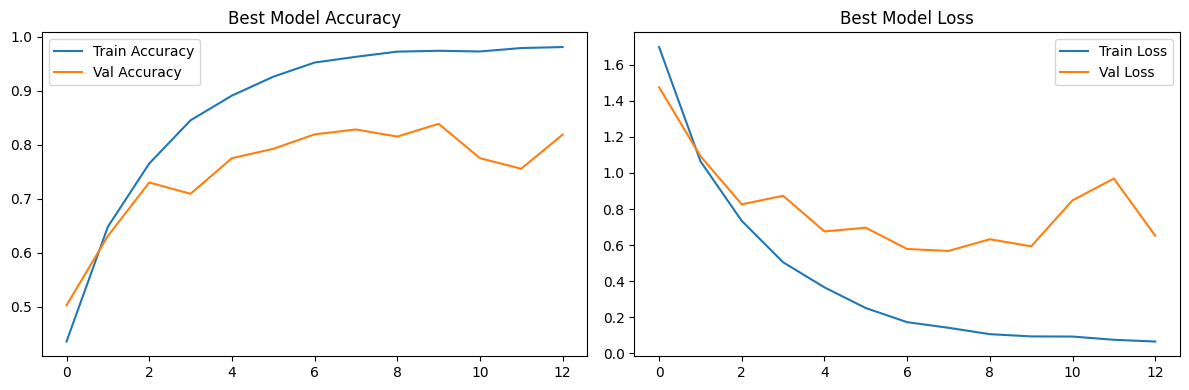

In [27]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title(f"Best Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"Best Model Loss")
plt.legend()

plt.tight_layout()
plt.show()


## Implement Hyperparameter Tuning for the 101x101 Model

In [28]:
# Define the model-building function for Keras Tuner
def build_101_model_with_hyperparameters(hp):
    tuned_101_model = models.Sequential()
    
    # Conv Layer 1
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(101, 101, 1)
    ))
    tuned_101_model.add(layers.BatchNormalization())
    tuned_101_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    tuned_101_model.add(layers.BatchNormalization())
    tuned_101_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    tuned_101_model.add(layers.BatchNormalization())
    
    tuned_101_model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    tuned_101_model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    tuned_101_model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    tuned_101_model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    tuned_101_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return tuned_101_model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_101_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=50,
    directory='kt_dir',
    project_name='improved_101_model_tuning'
)

Reloading Tuner from kt_dir\improved_101_model_tuning\tuner0.json


In [29]:
# Run hyperparameter tuning
tuner.search(
    train_101,  # Training dataset
    validation_data=val_101,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")
 

Trial 50 Complete [00h 02m 03s]
val_accuracy: 0.5981818437576294

Best val_accuracy So Far: 0.9709091186523438
Total elapsed time: 11h 23m 20s
Best Hyperparameters: {'conv_1_filters': 96, 'conv_2_filters': 256, 'conv_3_filters': 384, 'dense_units': 384, 'dropout_rate': 0.4, 'learning_rate': 2.6233713088320727e-05}


In [30]:
# Build and train the model with the best hyperparameters
tuned_101_model = tuner.hypermodel.build(best_hps)
history = tuned_101_model.fit(
    train_101,  # Training dataset
    validation_data=val_101,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)


Epoch 1/50
241/241 [==============================] - 26s 106ms/step - loss: 1.8924 - accuracy: 0.3800 - val_loss: 1.8321 - val_accuracy: 0.4041
Epoch 2/50
241/241 [==============================] - 27s 111ms/step - loss: 1.4909 - accuracy: 0.5325 - val_loss: 1.3848 - val_accuracy: 0.5732
Epoch 3/50
241/241 [==============================] - 26s 109ms/step - loss: 1.2728 - accuracy: 0.6098 - val_loss: 1.1822 - val_accuracy: 0.6359
Epoch 4/50
241/241 [==============================] - 26s 107ms/step - loss: 1.1268 - accuracy: 0.6575 - val_loss: 1.0269 - val_accuracy: 0.6959
Epoch 5/50
241/241 [==============================] - 26s 108ms/step - loss: 1.0080 - accuracy: 0.6974 - val_loss: 0.9265 - val_accuracy: 0.7255
Epoch 6/50
241/241 [==============================] - 26s 109ms/step - loss: 0.9158 - accuracy: 0.7302 - val_loss: 0.8448 - val_accuracy: 0.7382
Epoch 7/50
241/241 [==============================] - 49s 203ms/step - loss: 0.8268 - accuracy: 0.7622 - val_loss: 0.7451 - val_ac

In [31]:
# Evaluate the best model
test_loss, test_acc = tuned_101_model.evaluate(test_101)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


69/69 [==============================] - 2s 22ms/step - loss: 0.1316 - accuracy: 0.9650
Test Accuracy: 0.9650
Test Loss: 0.1316


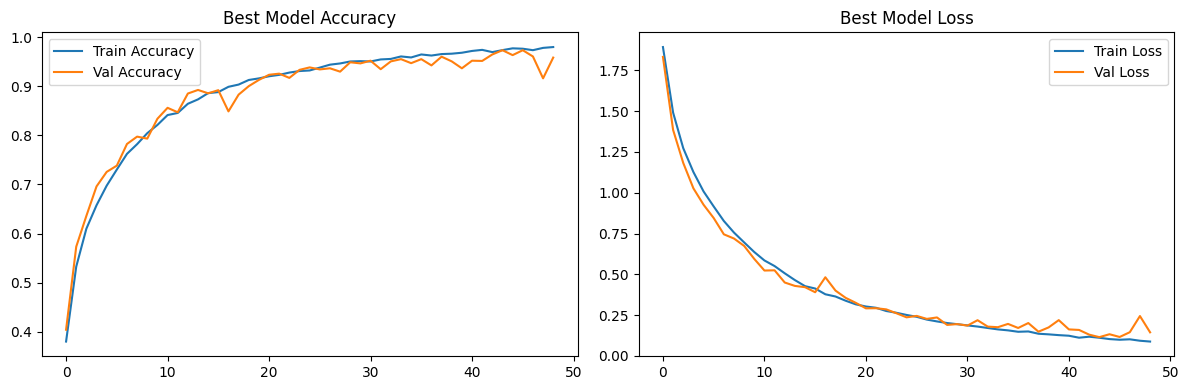

In [32]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title(f"Best Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"Best Model Loss")
plt.legend()

plt.tight_layout()
plt.show()